<img src="../Figures/Unipd_1.png" width="300"  align="left" height="300">

# Bayesian Blocks

#### author : 
George Pantelimon Prodan - Melika Keshavarzmirzamohammadi
#### created : 01-07-2022

#### Table Of Contents
1. [Introduction](#1.-Introduction:)

2. [Objective](#2.-Objective:)

3. [Method](#3.-Method:)



### 1. Introduction:
Bayesian Blocks is a time-domain algorithm for detecting localized structures (bursts), revealing pulse shapes, and generally characterizing intensity variations. The input is raw counting data, in any of three forms: time-tagged events(TTE), binned counts, or time-to-spill data. The output is the most probable segmentation of the observation into time intervals during which the amplitude is perceptibly constant, i.e. has no statistically significant variations. The idea is not that the times series of events is deemed to have this discontinuous, piecewise constant form, rather that such an approximate and generic model is often useful. The analysis is based on Bayesian statistics.


### 2. Objective:

The method was first used to address the problem of detecting and characterizing local variability in time series and other forms of sequential data in astronomical data. The main objective of this method is to design a histogram that fits to the data well in a way that it distinguishes between observational errors and statistical significance. 

## 3. Method:

______________________________________________________________________________________________






### 3.1. Blockwise Model :

The range of independent variables(e.g., time) are divided into subintervals(called blocks) which are normally unequal in size. The dependent variables(e.g., intensity) are usually constant within errors in a single block. In more complicated models one might use linear or exponential functions to show the dependency of the variables within blocks, in this paper, however, it is not needed to increase the complexity when the data is well-presented with the constant model. 

Defining the times ending one block and starting the next as change points, the model of the whole observation interval contains these parameters:


$1. N_{cp}:$ The number of change points. 


$2. t_{k}^{cp}:$ The change-point starting block K (and ending block (k-1))

$3. X_{k}:$ The signal amplitude in block K.


$ K = 1, 2, 3, ....., N_{cp} + 1$


* it is important to mention that the first datum is always considered the first change-point; therefore, it is not a free parameter.


In [8]:
install.packages("svMisc")
library(svMisc)
library('lubridate')
library(dplyr)
library(lubridate)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done

Attaching package: ‘svMisc’

The following object is masked from ‘package:utils’:

    ?


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘dplyr’

The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [9]:
#defining the fitness function:
logf <- function(N_k, T_k){
    return(N_k * log(N_k/T_k))
}

In [10]:
#The fitness function = Cash#

BB <- function(x) {
    
    #for atomic data vectors(1D):
    if (class(x) == 'numeric') {
        x_sorted = sort(x)
        x_unique <- c(x_sorted[1])
        x_weight <- c(1)
        for(i in 2:length(x_sorted)) {
            #adding weight if it is repeated:
            if(x_sorted[i] == x_sorted[i-1]) {
            x_weight[length(x_weight)] <- x_weight[length(x_weight)] + 1
            }
            else {
            x_unique <- c(x_unique, x_sorted[i])
            x_weight <- c(x_weight, 1)
            }
        }    
    }#---------------------------------------------------------- 
           
    #For histogram data:        
    else if (class(x) == 'histogram') {
        eg <- data$breaks
        x_unique <- c(eg[1],data$mids,eg[length(eg)])
        x_weight <- c(1,data$counts,1)
    }        
    else {
        stop('The data type is not supported! Please input numeric vectors or histograms')
        
    }#------------------------------------------------------------ 
    
                
     #Final number of data points:       
    N = length(x_unique) 
    
    

    
    

    
    #defining a prior dis function:
    logp <- function(prior) {
        if(prior == 'uniform') {
            return(0)
        }
        else if(prior == 'gamma') {
            #gamma = as.numeric(readline('input the parameter gamma: '))
            gamma = 0.01
            return(-log(gamma))
        }
        else if(prior == 'p0') {
            #p0 = as.numeric(readline('input the parameter p0: '))
            p0 = 0.01
            return( log(73.53 * p0 * N^(-0.478)) - 4)
            
        }
        else {
            stop('No Prior Distribution input!')
        }
        
    }
        
    x <- x_unique
    
    #input one of these:
    #1.uniform           2.gamma              3.p0
    prior_input = readline('Please input the type of prior distribution: ')
        
    #calculating the prior:
    ncp_prior = logp(prior = prior_input)
         
        
    #array of all possible edges:
    edges <- c(x[1], 0.5*(x[1:(length(x)-1)] + x[2:length(x)]), x[length(x)])
    
   
    best = c()
    last = c()
        
        
    F <- function(r, k){
    return(logf(sum(x_weight[r:k]), edges[k+1] - edges[r]) + ncp_prior)
    } 
        
    for (k in 1:N){
    A <- c()
    for (r in 1:k){
        A <- c(A, F(r, k)+ if(r==1) 0 else best[r-1])
    }
    last <- c(last, which.max(A))
    best <- c(best, max(A, na.rm=TRUE))
    progress(k, N, progress.bar=TRUE)
    if (k == N) message("Done!")
    }
    
               
    
               
    cp <- c()
    i <- N + 1
    while(i!=0){
        cp <- c(cp, i)
        i = (if(i == 1) 0 else last[i - 1])
    }

    y <- c()
    for (j in cp[length(cp):1]){
        y <- c(y, edges[j])
    }
    return(y)
   
    
}

In [11]:
# producing some fake data to see the result for it:
data = c(rnorm(1000, mean = 0), rcauchy(1000, 5))
data = data[data> -5 & data<10]

typeof(data)

[1] "double"

In [12]:
breaks = BB(data)

Please input the type of prior distribution: p0
          0-----------------------------------------------------------------1897
Progress: ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Done!


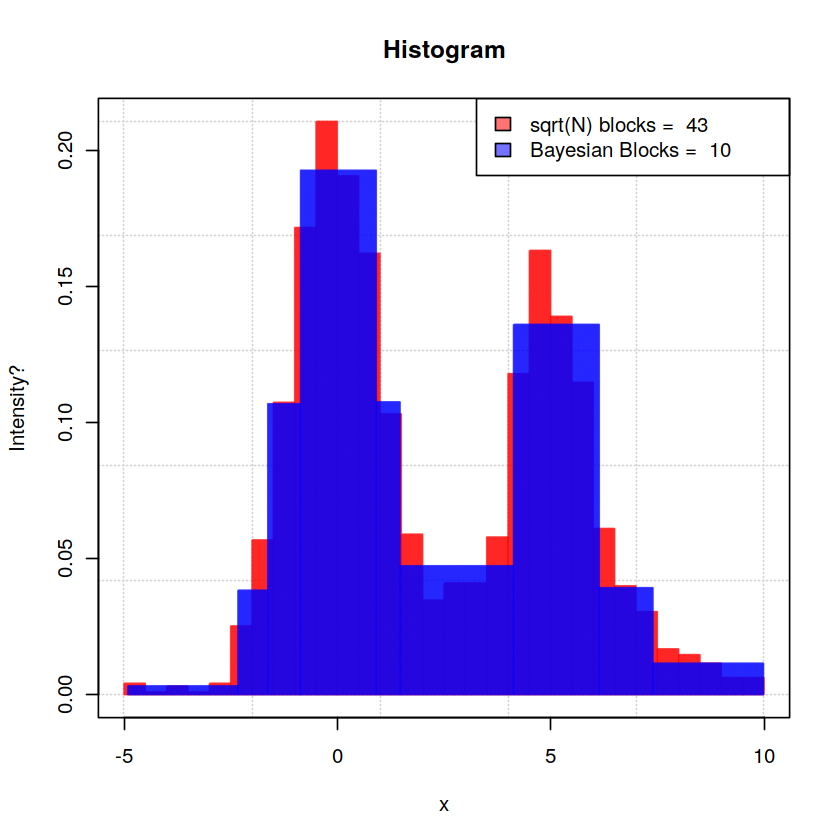

In [13]:
N <- length(data)

col1 = scales::alpha(2,.55)
col2 = scales::alpha(4,.55)

# sqrt(N)
hist(data,breaks=sqrt(N),freq=FALSE,col=col1,border=F, panel.first=grid(),density=200,
     xlab='x',ylab='Intensity?',main=('Histogram'))
# Bayesian Blocks
hist(data,breaks=breaks,density=200, col=col2,border=F,add=T)

text_legend <- c(sprintf("sqrt(N) blocks = %3i",floor(sqrt(N))), sprintf("Bayesian Blocks = %3i",length(breaks)))

legend("topright", 
       legend=text_legend,
       fill=c(col1, col2),
       text.width = strwidth(text_legend)[2]/2)
box()


__________________________________________________________________________

# Bayesian Blocks In Stock Market:



## Stock market index:

A single Index in stock market measures the performance of a collection of stocks. The main idea of Indexes is to have a larger picture of performance of market and not focusing too much on a single stock.

## S&P 500 index:


The S&P 500 index measures the performance of 500 of the largest publicly traded companies in the U.S. Due to its broader exposure, Experts believe that S&P 500 index is the best index for tracking fluctuations in the US stock market. This index is weighted by market cap, which is the **number** of a **company's outstanding shares** multiplied by **price per share**. Therefore, the companies with the largest total market value have the greatest impact on the average of the S&P 500 index.



The most problematic part of studying stock market is anticipating the health of market in general. The main reason of this problem is that the stock prices follow the brownian motion which is a quite random process in a sence that the next step of the stock price is only dependent on the current price of the stock and not on the previous prices.

$$\large\frac{ds}{s} = \mu dt + \sigma dz $$

s: price of the stock.

$\mu$: drift rate.

$\sigma$: fluctuaions (volatility).






## Studying history of market is useful:

However, experts believe that modeling and measuring the previous fluctuation of the indexes and stock prices themselves is beneficial due to the fact that it demonstrate some facts about the overall behaviour of the market.


one of the most catastrophic crashes that the market has ever experienced was in Covid 19 pandamic. There are a lot to scrutinize about the performance of a single company with respect to the S&P 500 index and search for the companies for the most impact of the dramatic decrease in the index.

<span style="color:forestgreen ; font-size:150%"> S&P500 Index and Bayesian Blocks algorithm:</span> <a class="anchor" id="3.1.1"></a>

In [14]:
#Stock market




SP = read.csv('/Users/melikakeshavarz/Desktop/adv/SPX_HistoricalData.csv')



Date = as.character(SP$Date)

#year/month/day
SP$Date = mdy(Date)
Date = SP$Date

#checking the years:
#year(Date)

#plotting 
par(mfrow=c(1,1))
options(repr.plot.width=20, repr.plot.height=8)


plot(Date, SP$High, type = 'l', col = 'forestgreen', xlab = 'Dates', ylab = 'Highest price[$]', main = 'S&P', panel.first = grid(), lwd = 2)



Warning message in file(file, "rt"):
“cannot open file '/Users/melikakeshavarz/Desktop/adv/SPX_HistoricalData.csv': No such file or directory”

ERROR: Error in file(file, "rt"): cannot open the connection


In [15]:
#filtering the data from Covid 19 economic crisis:
#----------------------------------------------------------------------------------------------------------------------
SP %>% filter(between(Date, as.Date('2020-01-01'), as.Date('2022-01-01'))) -> SP


#checking the years:
#year(SP$Date)




#######How to make it a historam?
#approximation in oder to get round data:
SP$High<-as.integer(SP$High)

######The matrix of date destribution w.r.t Highest price:
MatData <- matrix(0,nrow=sum(SP$High),ncol=1)

k <- 1


for(i in 1:dim(SP)[1]){
  L <- SP$High[i]
  if(L!=0){
    MatData[k:(k+L-1)] <- rep(SP$Date[i],L)
    k <- k + L
  }
  else{
    pass
  }
}

#omitting zero values:
MatData[MatData==0] <- NA
na.omit(MatData)
#head(MatData, 20)

#Checking%
MatData<-sort(MatData)

#Converting number of days to dates:
MData = as.Date(MatData, origin = '1970-01-01')
#head(MData, 20)









ERROR: Error in eval(lhs, parent, parent): object 'SP' not found


In [16]:
#applying the Bayesin Blocks to the stock market data:

#PIROR = P0
#-------------------------------------------------------------------------------

BB_breaks <- BB(MatData)


myhist <- hist(MData, breaks= 260, plot = F) #The hist with equal bins.
BBhist <- hist(MatData , breaks= BB_breaks, plot= F)#The Bayesian bins.


# S&P highest price during Covid19:
par(mfrow=c(1,1))
options(repr.plot.width=20, repr.plot.height=8)

#with equal breaks:
plot(x=myhist$breaks[1:length(myhist$breaks)],log = 'y', y= length(MatData) *c(myhist$density,tail(myhist$density,n=1)), panel.first=grid(),
     col='forestgreen',lwd=1.5, type='h', xlab='Date',ylab='Highest price in a day',
     main="Histogram of S&P 500 index during Covid19", xaxt = "n" )
# Bayesian Blocks plot:
lines(x=BBhist$breaks[1:length(BBhist$breaks)], y= length(MatData) * c(BBhist$density,tail(BBhist$density,n=1)), type='s', lwd=1.5,col='tomato')
axis.Date(1, at=seq(min(SP$Date), max(SP$Date), by="1 mon"), format="%m/%Y")
legend("top", inset=+0,legend=c(sprintf("Fixed number of edges: %3i",length(myhist$breaks)),sprintf("Bayesian Blocks(p0 prior): %3i",length(BBhist$breaks))),
       col=c("forestgreen","tomato"),lty=c(1,1), lwd=c(3, 3), cex=0.8,box.lty=0, border=F)





ERROR: Error in BB(MatData): object 'MatData' not found


<div class="alert alert-block alert-info"> <b>INFO: </b>
As shown above the Bayesian Blocks algorithm highlitghts the main features of the stock market by recognizing the main and most important fluctuations. 
</div>




Please input the type of prior distribution: uniform


Done!
Warning message in length(cp):-1:1:
“numerical expression has 574 elements: only the first used”

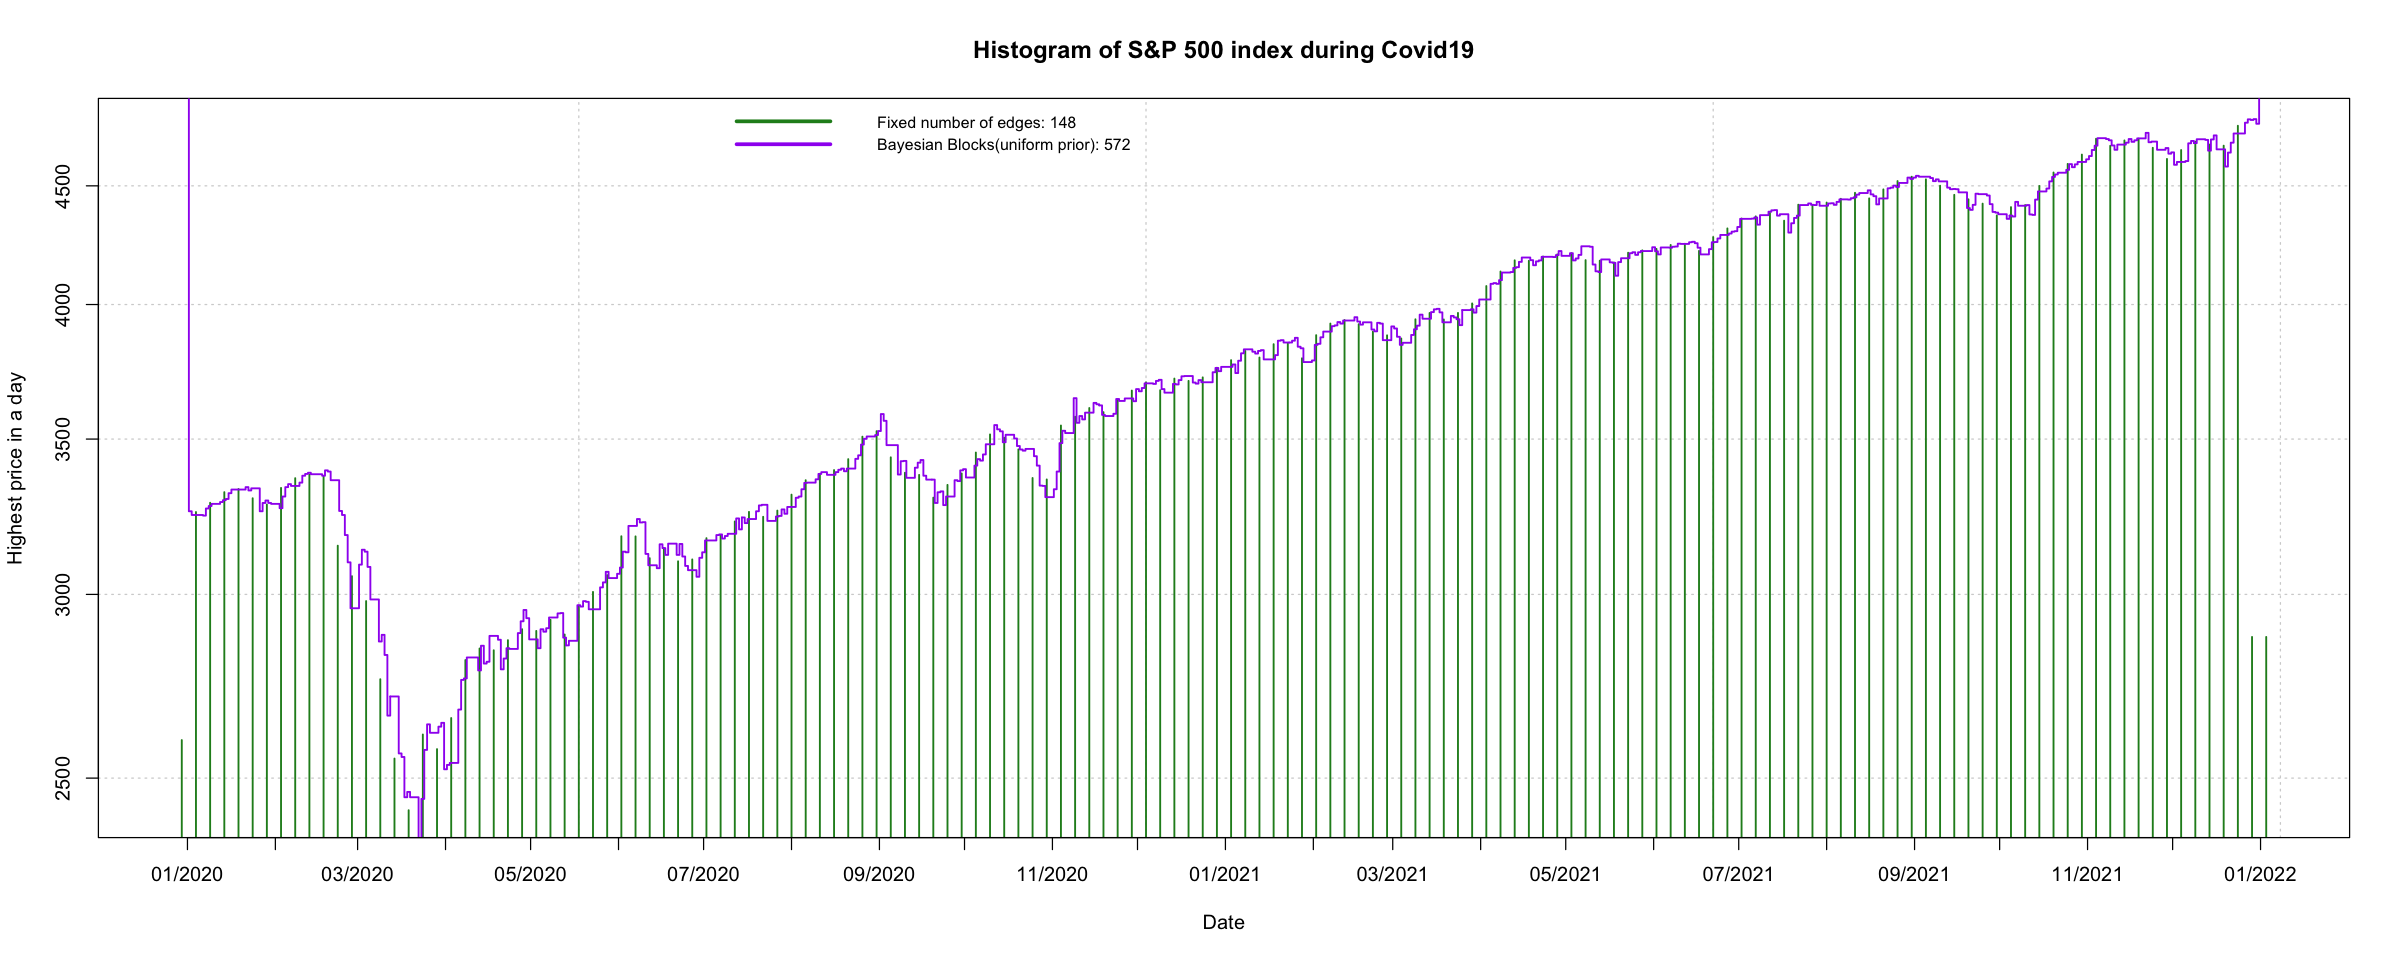

In [19]:
#PRIOR = Uniform
#-------------------------------------------------------------------------------

BB_breaks <- BB(MatData)


myhist <- hist(MData, breaks= 260, plot = F) #The hist with equal bins.
BBhist <- hist(MatData , breaks= BB_breaks, plot= F)#The Bayesian bins.


# S&P highest price during Covid19:
par(mfrow=c(1,1))
options(repr.plot.width=20, repr.plot.height=8)

#with equal breaks:
plot(x=myhist$breaks[1:length(myhist$breaks)],log = 'y', y= length(MatData) *c(myhist$density,tail(myhist$density,n=1)), panel.first=grid(),
     col='forestgreen',lwd=1.5, type='h', xlab='Date',ylab='Highest price in a day',
     main="Histogram of S&P 500 index during Covid19", xaxt = "n" )
# Bayesian Blocks plot:
lines(x=BBhist$breaks[1:length(BBhist$breaks)], y= length(MatData) * c(BBhist$density,tail(BBhist$density,n=1)), type='s', lwd=1.5,col='purple')
axis.Date(1, at=seq(min(SP$Date), max(SP$Date), by="1 mon"), format="%m/%Y")
legend("top", inset=+0,legend=c(sprintf("Fixed number of edges: %3i",length(myhist$breaks)),sprintf("Bayesian Blocks(uniform prior): %3i",length(BBhist$breaks))),
       col=c("forestgreen","purple"),lty=c(1,1), lwd=c(3, 3), cex=0.8,box.lty=0, border=F)



As it is depicted above the uniform prior fits the data almost completely in a way that shows almost all of the noises and on the top of critical changes.

Please input the type of prior distribution: gamma


Done!
Warning message in length(cp):-1:1:
“numerical expression has 735 elements: only the first used”

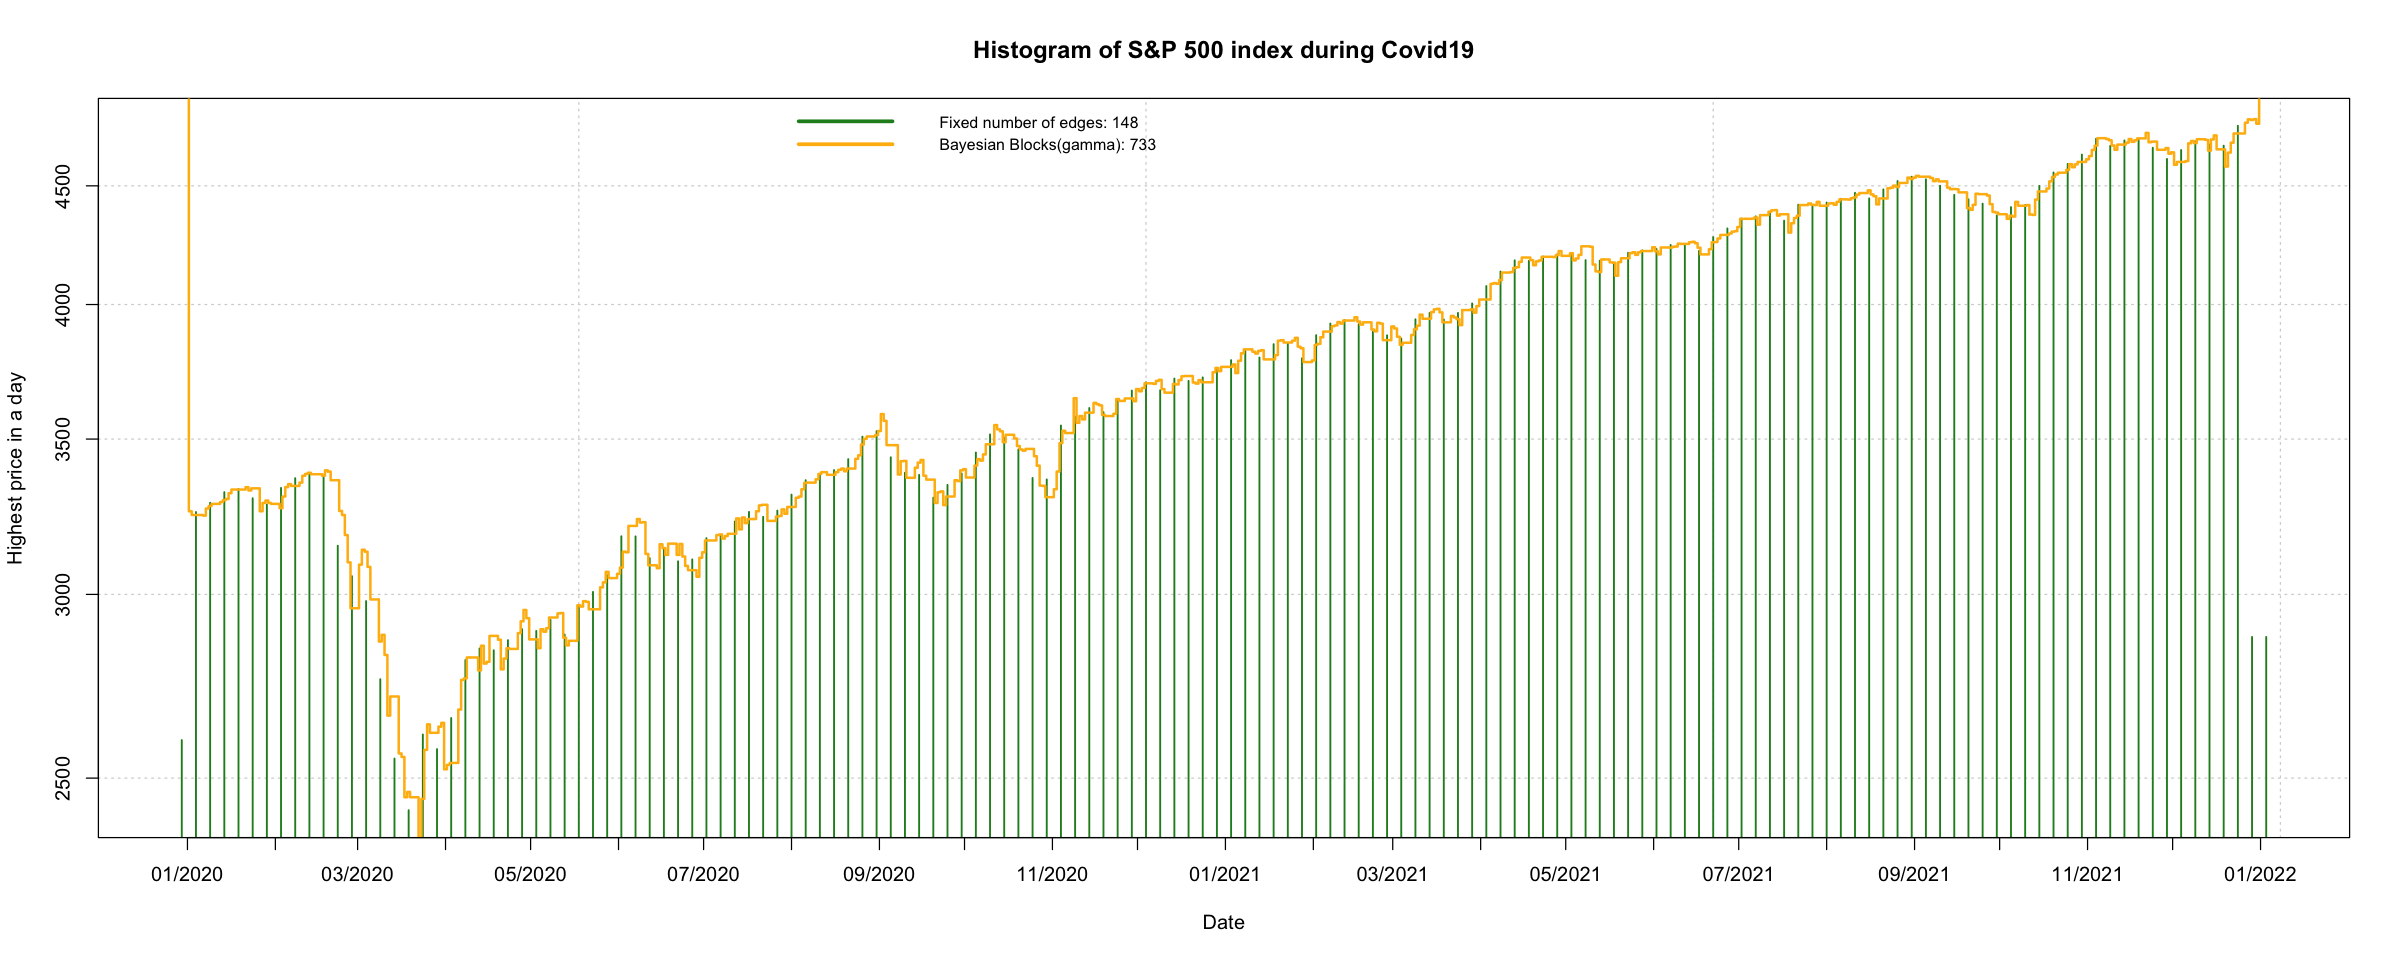

In [20]:
#PRIOR = gamma
#-------------------------------------------------------------------------------

BB_breaks <- BB(MatData)


myhist <- hist(MData, breaks= 260, plot = F) #The hist with equal bins.
BBhist <- hist(MatData , breaks= BB_breaks, plot= F)#The Bayesian bins.


# S&P highest price during Covid19:
par(mfrow=c(1,1))
options(repr.plot.width=20, repr.plot.height=8)

#with equal breaks:
plot(x=myhist$breaks[1:length(myhist$breaks)],log = 'y', y= length(MatData) *c(myhist$density,tail(myhist$density,n=1)), panel.first=grid(),
     col='forestgreen',lwd=1.5, type='h', xlab='Date',ylab='Highest price in a day',
     main="Histogram of S&P 500 index during Covid19", xaxt = "n" )
# Bayesian Blocks plot:
lines(x=BBhist$breaks[1:length(BBhist$breaks)], y= length(MatData) * c(BBhist$density,tail(BBhist$density,n=1)), type='s', lwd=2,col='darkgoldenrod1')
axis.Date(1, at=seq(min(SP$Date), max(SP$Date), by="1 mon"), format="%m/%Y")
legend("top", inset=+0,legend=c(sprintf("Fixed number of edges: %3i",length(myhist$breaks)),sprintf("Bayesian Blocks(gamma): %3i",length(BBhist$breaks))),
       col=c("forestgreen","darkgoldenrod1"),lty=c(1,1), lwd=c(3, 3), cex=0.8,box.lty=0, border=F)



# Volatility Of Stock Market:






## What Is VIX Index:


In periods of high global economic uncertainty like today, the markets tend to be extremely volatile. Volatility is negatively correlated to stock market returns which means that it increases when returns decline and vice versa. For a balanced portfolio, traders must include an asset that is positively correlated with volatility. 

The CBOE Volatility Index (VIX) measures the market sentiment on volatility. As a result, it gains the most during periods of uncertainty and high volatility. The VIX uses the S&P 500 Index (SPX) options to forecast volatility for the next 30 days. Trading with the VIX involves buying products that track the volatility index. 


Volatility indices were first proposed in 1989 by two researchers, Menachem Brenner and Dan Galai. The duo recommended the volatility index to be named Sigma and to be updated frequently and used as a derivative for futures and options. 


In 1992, the Chicago Board Options Exchange (CBOE) engaged a consultant by the name of Bob Whaley to compute the values for stock market volatility using the approach proposed by Brenner and Galai. Whaley used data series in the index options market to calculate daily VIX levels from January 1986 to May 1992. 



**The Cboe Volatility Index, or VIX, is a real-time market index representing the market’s expectations for volatility over the coming 30 days.**

**Investors use the VIX to measure the level of risk, fear, or stress in the market when making investment decisions.
Traders can also trade the VIX using a variety of options and exchange-traded products, or they can use VIX values to price derivatives.**

**The VIX generally rises when stocks fall, and declines when stocks rise.**


<span style="color:forestgreen ; font-size:150%">VIX and Bayesian Blocks algorithm:</span> <a class="anchor" id="3.1.1"></a>

In [106]:
VIX = read.csv('/Users/melikakeshavarz/Desktop/adv/vix-volatility-index-historical-chart.csv')
VIX$date<-sapply(VIX$date, as.character)

VIX$date = ymd(VIX$date)


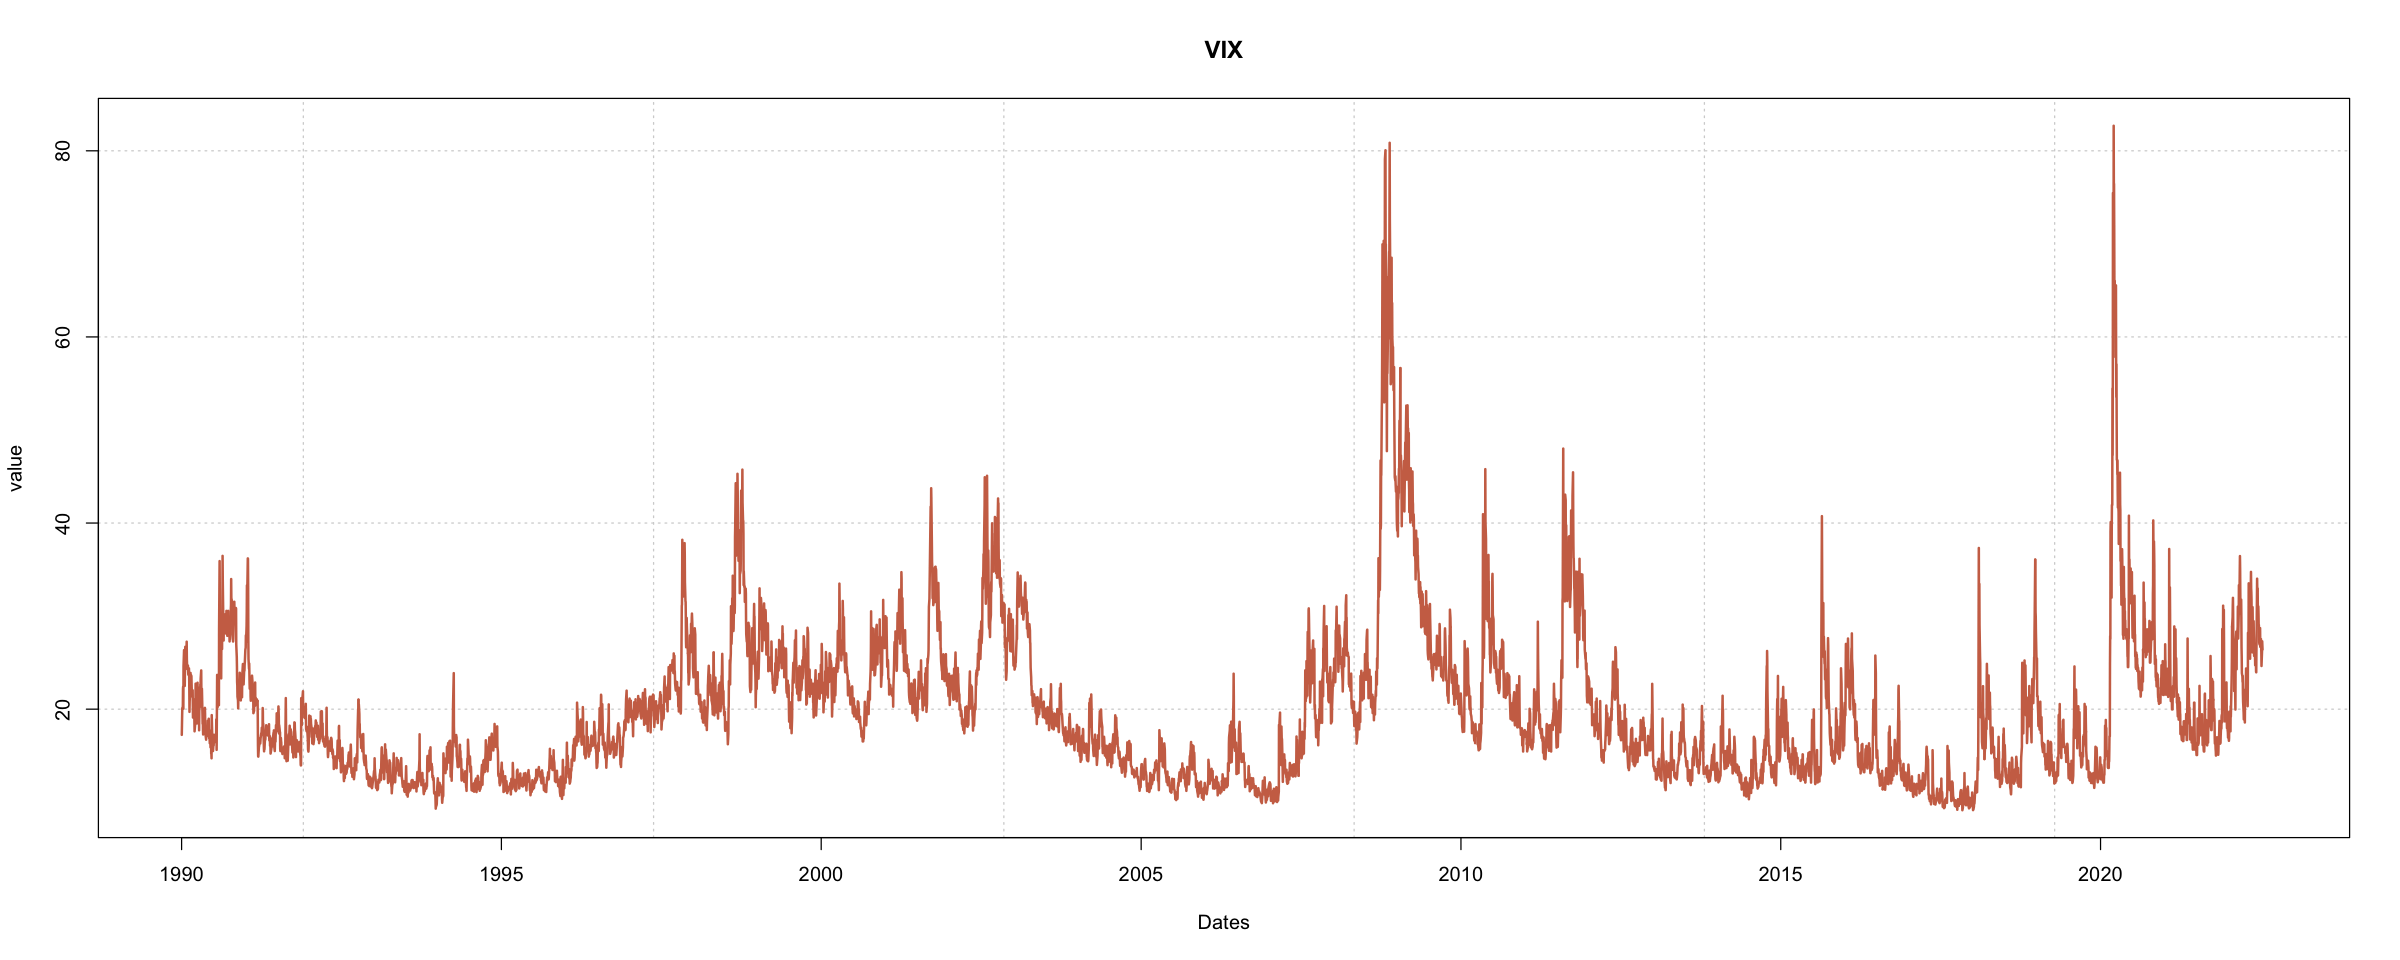

In [107]:
#plotting VIX from 1990 to 2022
par(mfrow=c(1,1))
options(repr.plot.width=20, repr.plot.height=8)


plot(VIX$date, VIX$value, type = 'l', col = 'salmon3', xlab = 'Dates', ylab = 'value', main = 'VIX', panel.first = grid(), lwd = 2)



In [ ]:
#filtering the data from Covid 19 economic crisis:
#----------------------------------------------------------------------------------------------------------------------
VIX %>% filter(between(date, as.Date('2020-01-01'), as.Date('2022-01-01'))) -> VIX


#checking the years:
year(VIX$date)




#######How to make it a historam?
#approximation in oder to get round data:
VIX$value<-as.integer(VIX$value)

######The matrix of date destribution w.r.t Highest price:
MatData <- matrix(0,nrow=sum(VIX$value),ncol=1)

k <- 1


for(i in 1:dim(VIX)[1]){
  L <- VIX$value[i]
  if(L!=0){
    MatData[k:(k+L-1)] <- rep(VIX$date[i],L)
    k <- k + L
  }
  else{
    pass
  }
}

#omitting zero values:
MatData[MatData==0] <- NA
na.omit(MatData)
#head(MatData, 20)

#Checking%
MatData<-sort(MatData)

#Converting number of days to dates:
MData = as.Date(MatData, origin = '1970-01-01')
#head(MData, 20)






Please input the type of prior distribution: p0


Done!
Warning message in length(cp):-1:1:
“numerical expression has 14 elements: only the first used”

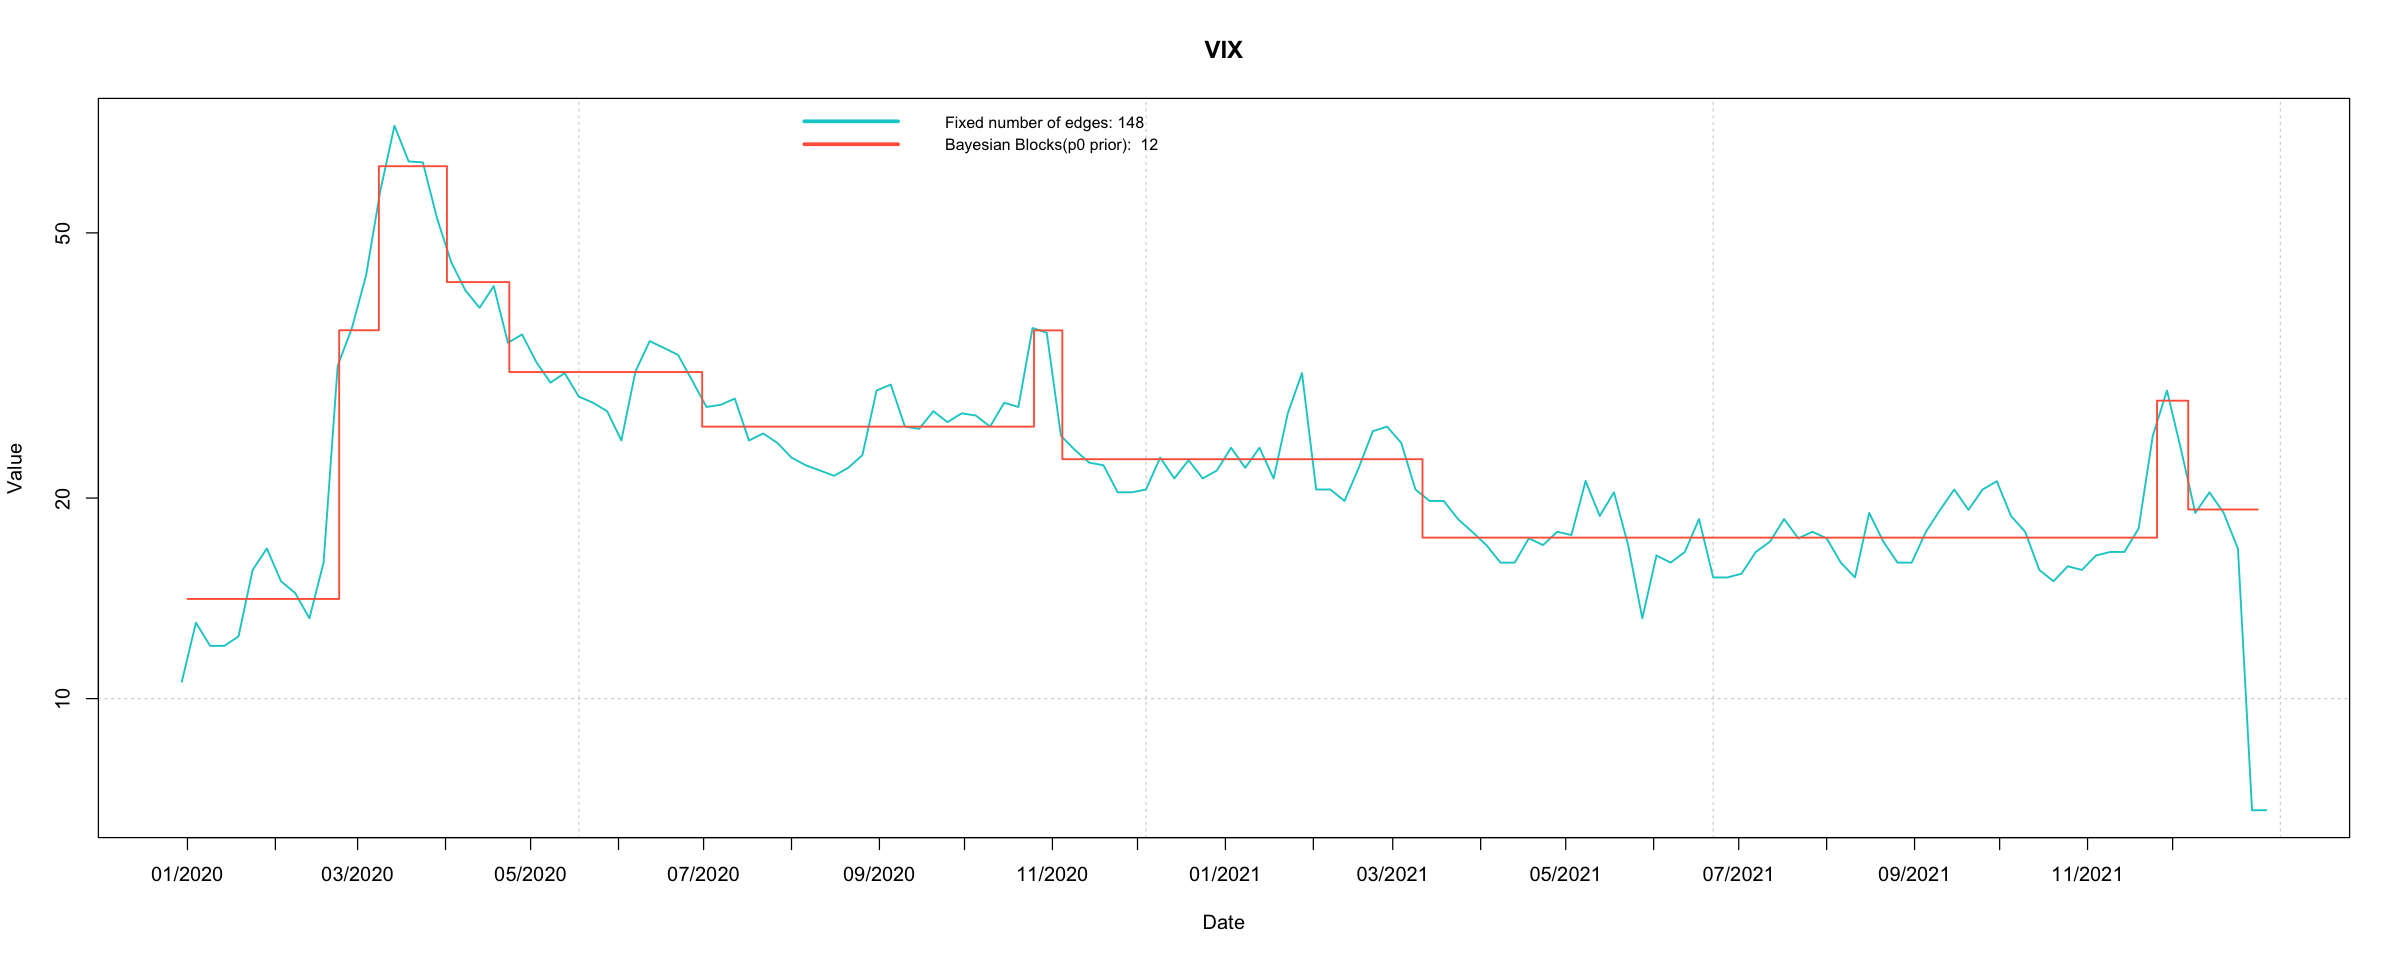

In [97]:
#applying the Bayesin Blocks to VIX:

#PIROR = P0
#-------------------------------------------------------------------------------

BB_breaks <- BB(MatData)


myhist <- hist(MData, breaks= 260, plot = F) #The hist with equal bins.
BBhist <- hist(MatData , breaks= BB_breaks, plot= F)#The Bayesian bins.


# S&P highest price during Covid19:
par(mfrow=c(1,1))
options(repr.plot.width=20, repr.plot.height=8)

#with equal breaks:
plot(x=myhist$breaks[1:length(myhist$breaks)],log = 'y', y= length(MatData) *c(myhist$density,tail(myhist$density,n=1)), panel.first=grid(),
     col='cyan3',lwd=1.5, type='l', xlab='Date',ylab='Value',
     main="VIX", xaxt = "n" )
# Bayesian Blocks plot:
lines(x=BBhist$breaks[1:length(BBhist$breaks)], y= length(MatData) * c(BBhist$density,tail(BBhist$density,n=1)), type='s', lwd=1.5,col='tomato')
axis.Date(1, at=seq(min(VIX$date), max(VIX$date), by="1 mon"), format="%m/%Y")
legend("top", inset=+0,legend=c(sprintf("Fixed number of edges: %3i",length(myhist$breaks)),sprintf("Bayesian Blocks(p0 prior): %3i",length(BBhist$breaks))),
       col=c("cyan3","tomato"),lty=c(1,1), lwd=c(3, 3), cex=0.8,box.lty=0, border=F)




Please input the type of prior distribution: uniform


Done!
Warning message in length(cp):-1:1:
“numerical expression has 427 elements: only the first used”

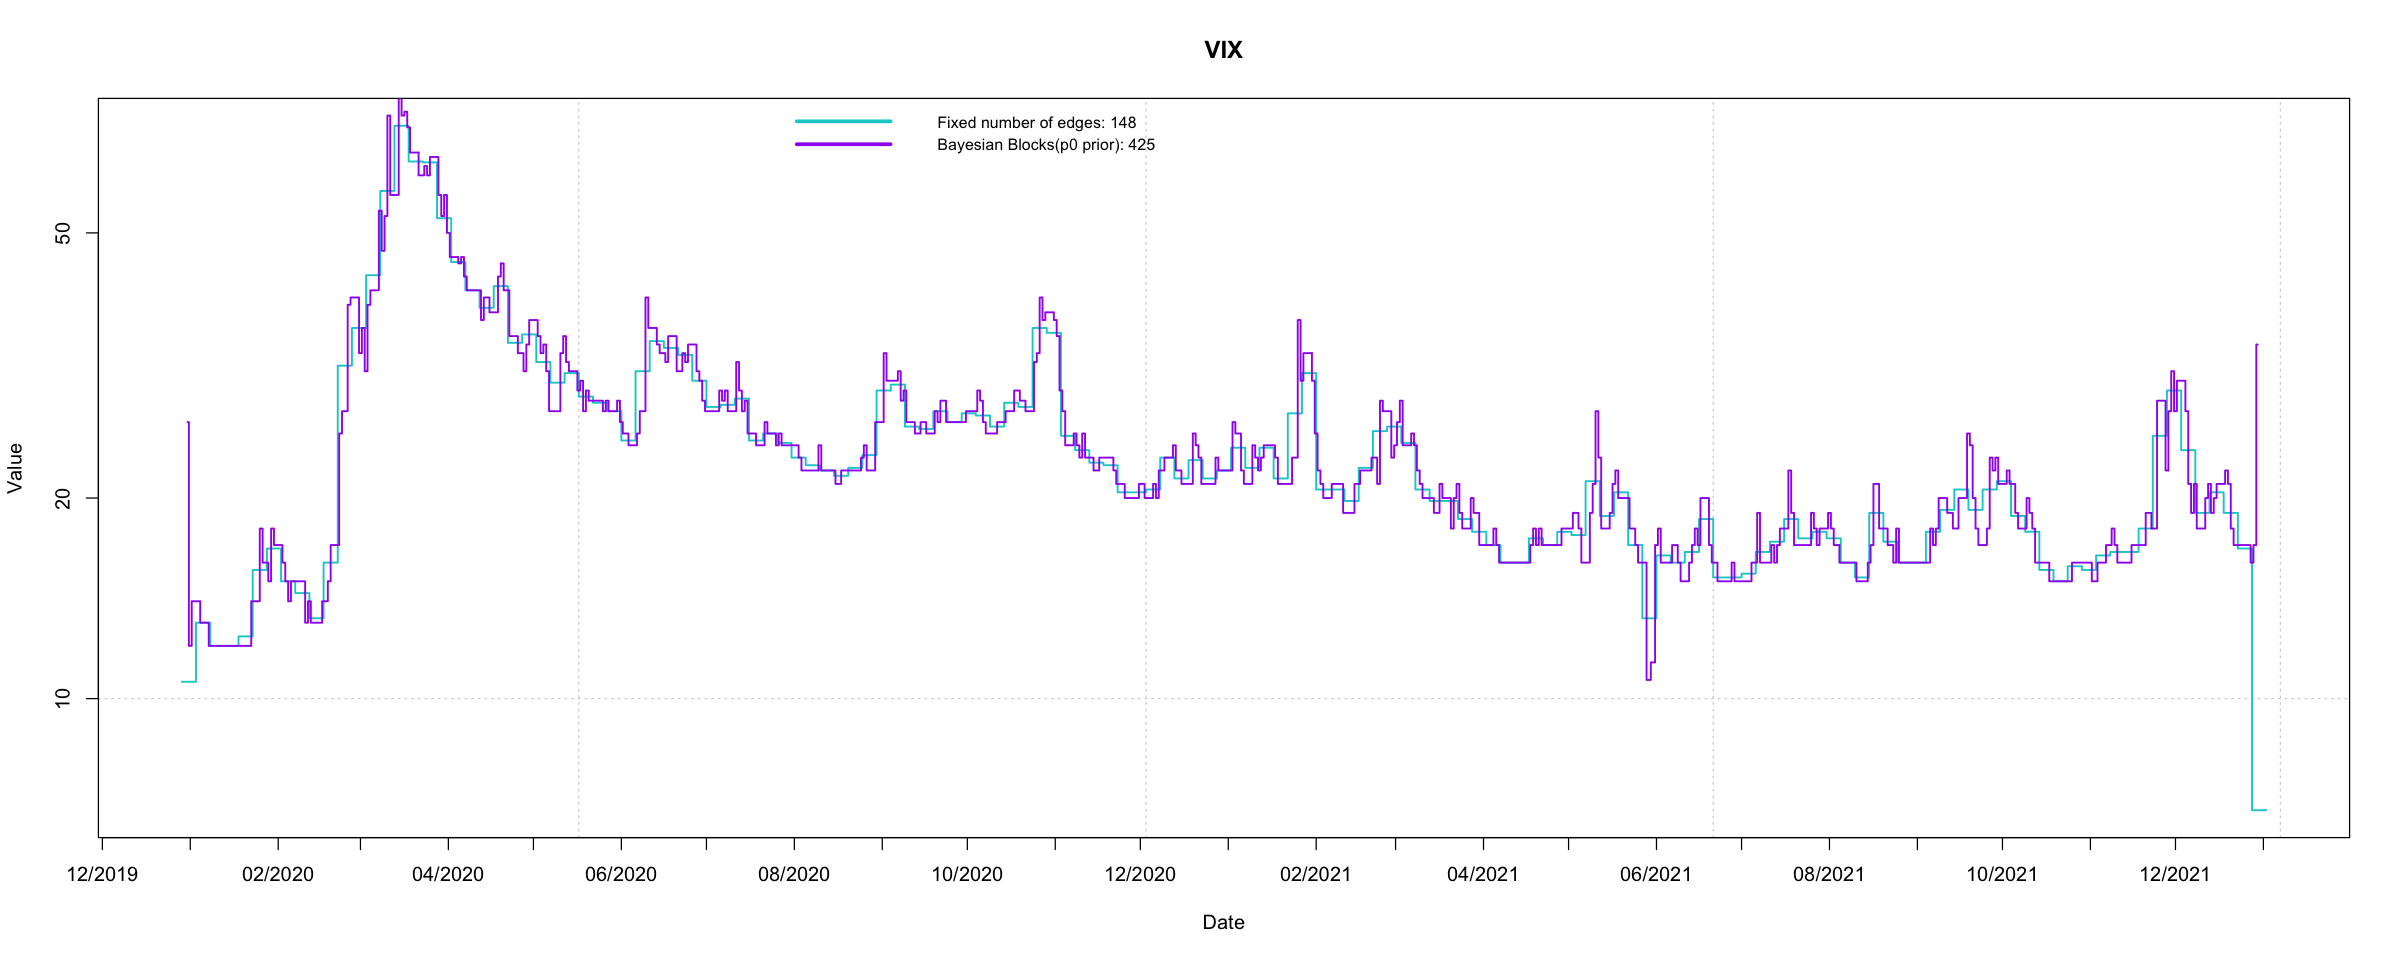

In [110]:
#PIROR = uniform
#-------------------------------------------------------------------------------

BB_breaks <- BB(MatData)


myhist <- hist(MData, breaks= 260, plot = F) #The hist with equal bins.
BBhist <- hist(MatData , breaks= BB_breaks, plot= F)#The Bayesian bins.


# S&P highest price during Covid19:
par(mfrow=c(1,1))
options(repr.plot.width=20, repr.plot.height=8)

#with equal breaks:
plot(x=myhist$breaks[1:length(myhist$breaks)],log = 'y', y= length(MatData) *c(myhist$density,tail(myhist$density,n=1)), panel.first=grid(),
     col='cyan3',lwd=1.5, type='s', xlab='Date',ylab='Value',
     main="VIX", xaxt = "n" )
# Bayesian Blocks plot:
lines(x=BBhist$breaks[1:length(BBhist$breaks)], y= length(MatData) * c(BBhist$density,tail(BBhist$density,n=1)), type='s', lwd=1.5,col='purple')
axis.Date(1, at=seq(min(VIX$date), max(VIX$date), by="1 mon"), format="%m/%Y")
legend("top", inset=+0,legend=c(sprintf("Fixed number of edges: %3i",length(myhist$breaks)),sprintf("Bayesian Blocks(p0 prior): %3i",length(BBhist$breaks))),
       col=c("cyan3","purple"),lty=c(1,1), lwd=c(3, 3), cex=0.8,box.lty=0, border=F)




Please input the type of prior distribution: gamma


Done!
Warning message in length(cp):-1:1:
“numerical expression has 733 elements: only the first used”

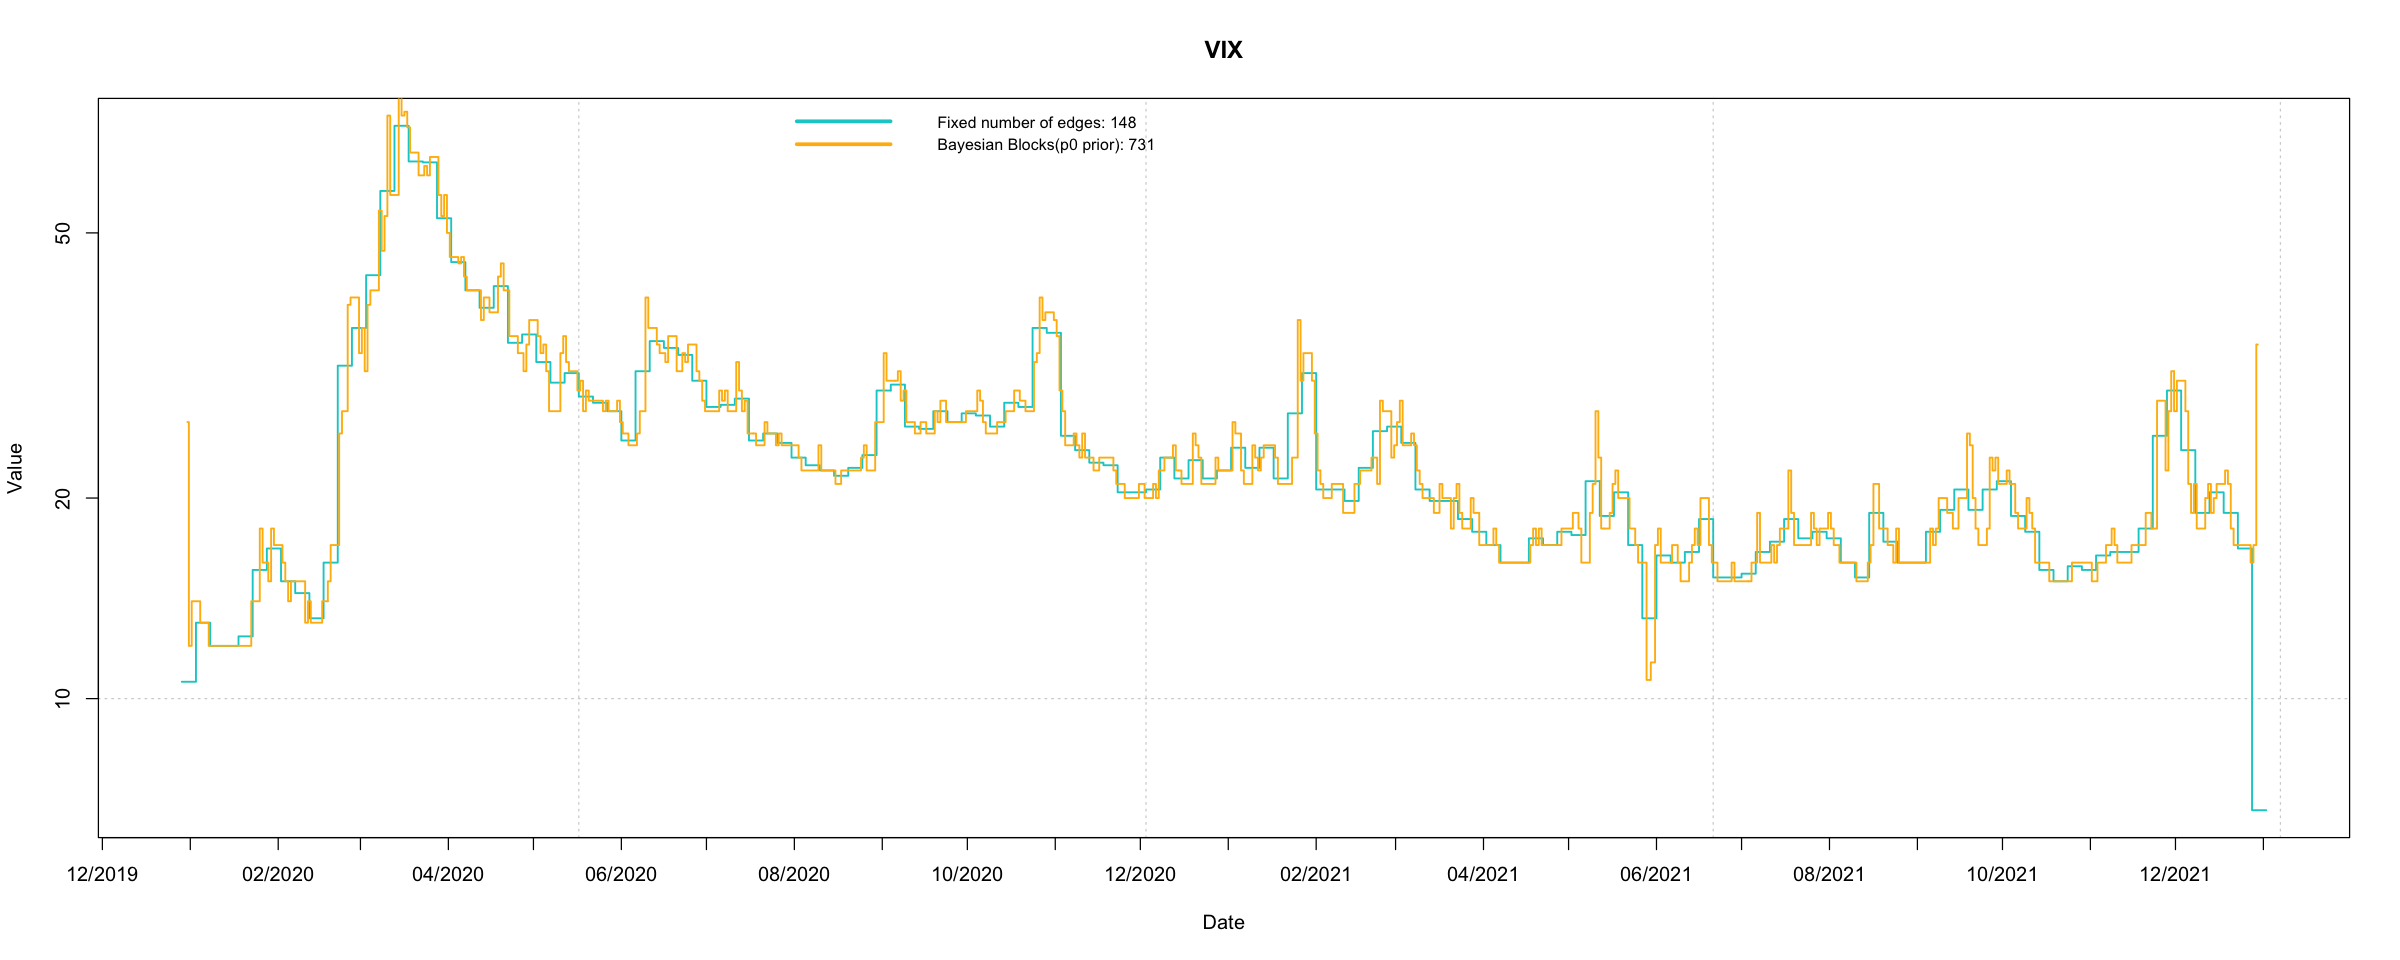

In [112]:
#PIROR = gamma
#-------------------------------------------------------------------------------

BB_breaks <- BB(MatData)


myhist <- hist(MData, breaks= 260, plot = F) #The hist with equal bins.
BBhist <- hist(MatData , breaks= BB_breaks, plot= F)#The Bayesian bins.


# S&P highest price during Covid19:
par(mfrow=c(1,1))
options(repr.plot.width=20, repr.plot.height=8)

#with equal breaks:
plot(x=myhist$breaks[1:length(myhist$breaks)],log = 'y', y= length(MatData) *c(myhist$density,tail(myhist$density,n=1)), panel.first=grid(),
     col='cyan3',lwd=1.5, type='s', xlab='Date',ylab='Value',
     main="VIX", xaxt = "n" )
# Bayesian Blocks plot:
lines(x=BBhist$breaks[1:length(BBhist$breaks)], y= length(MatData) * c(BBhist$density,tail(BBhist$density,n=1)), type='s', lwd=1.5,col='darkgoldenrod1')
axis.Date(1, at=seq(min(VIX$date), max(VIX$date), by="1 mon"), format="%m/%Y")
legend("top", inset=+0,legend=c(sprintf("Fixed number of edges: %3i",length(myhist$breaks)),sprintf("Bayesian Blocks(p0 prior): %3i",length(BBhist$breaks))),
       col=c("cyan3","darkgoldenrod1"),lty=c(1,1), lwd=c(3, 3), cex=0.8,box.lty=0, border=F)




__________________________________________________________________________

# Bayesian Blocks In Comet Tail Estimation



### About comets

Comets are one of the most spectacular astronomical objects that raised a multitude of questions throughout history.  Modern astronomers are studying the trajectory, structure, composition and origin of the comets since the eighteenth century, when the return of 1P/Halley’s comet was successfully predicted (in 1759) and when, also, the nongravitational motion of the comets was observed for the first time for 2P/Encke.

The structure of a comet was gradually explored starting from 1835, when the comet 1P/Halley visited again the inner Solar System.  Later on, at its apparition in 1985-1986 the ESA/Giotto space mission acquired the first in-situ images of 1P cometary nucleus. Moreover, the development of better cameras (CCDs - Charge Coupled Devices) in the late twentieth century contributed to an increased number of discoveries in cometary science.

 Any comet is usually composed by a nucleus, a coma, and two tails of dust and gas. The nucleus of a comet is small (a few kilometers in diameter) and invisible because of the coma brightness. The coma is a large cloud composed of gas and dust. A yellowish dust tail is formed by the tiny dust particles which are driven away by the solar radiation in a direction outward from the Sun. Also, for some comets there is a bluish tail of ions, which interact with the interplanetary magnetic fields lines and which are moving in the direction of the solar wind.


![alt text](image_comet.png "Comet image")
 
### Study case: 2I/Borisov

In this work, we focus on estimating the tail length of the comet. This is a challenging task because the tail becomes fainter as we are getting further away from the nucleus approaching the S/N limit. Using Bayesian Blocks we estimate this limit by getting the left edge of the last Bayesian block. We use the astropy library from Python to extract the radial intensity profile for three frames of the comet.

![alt text](4colors.png "Comet image")
 

In [17]:
library(gridExtra) # to put plots in a grid
library(ggplot2) 
library(glue)

In [18]:
data_files <- c("./1002_r_hist", "./1004_r_hist", "./1014_r_hist")
night <- 0
breaks <- rep(NULL, length(data_files))
data <- rep(NULL, length(data_files))
for (data_file in data_files){
    night <- night + 1
    arr_data <- read.table(data_file)$V2
    data[[night]] <- arr_data
    breaks[[night]] <- BB(data[[night]])
}

Please input the type of prior distribution: p0


Done!


Please input the type of prior distribution: p0


Done!


Please input the type of prior distribution: p0


Done!


In [ ]:
col1 = scales::alpha(1,.55)
col2 = scales::alpha(7,.45)
p <- rep(NULL, length(data_files))
for (i in 1:(length(data))){
    N <- length(data[[i]])
    # sqrt(N)
    df <- data.frame(x=data[[i]])
    p[[i]] <- ggplot(df, aes(x=200*(x+0.25*N/sqrt(N)))) + 
      geom_histogram(bins=sqrt(N), fill=col1, aes(y=..density..)) +
      geom_histogram(bins=length(breaks[[i]]), breaks=200*breaks[[i]], fill=col2, aes(y=..density..)) +
    labs(y= "density", x = "km") + ggtitle(data_files[[i]])+
    annotate(geom = "vline",
             x = c(200*breaks[[i]][length(breaks[[i]])-1]),
             xintercept = c(200*breaks[[i]][length(breaks[[i]])-1]),
             linetype = c("dashed")) +
    annotate(geom = "text",
             label = c(glue(round(200*breaks[[i]][length(breaks[[i]])-1], digits=5)," km")),
             x = c(200*breaks[[i]][length(breaks[[i]])-1]+400),
             y = c(0.0001),
             angle = 90, 
             vjust = 1) 
}

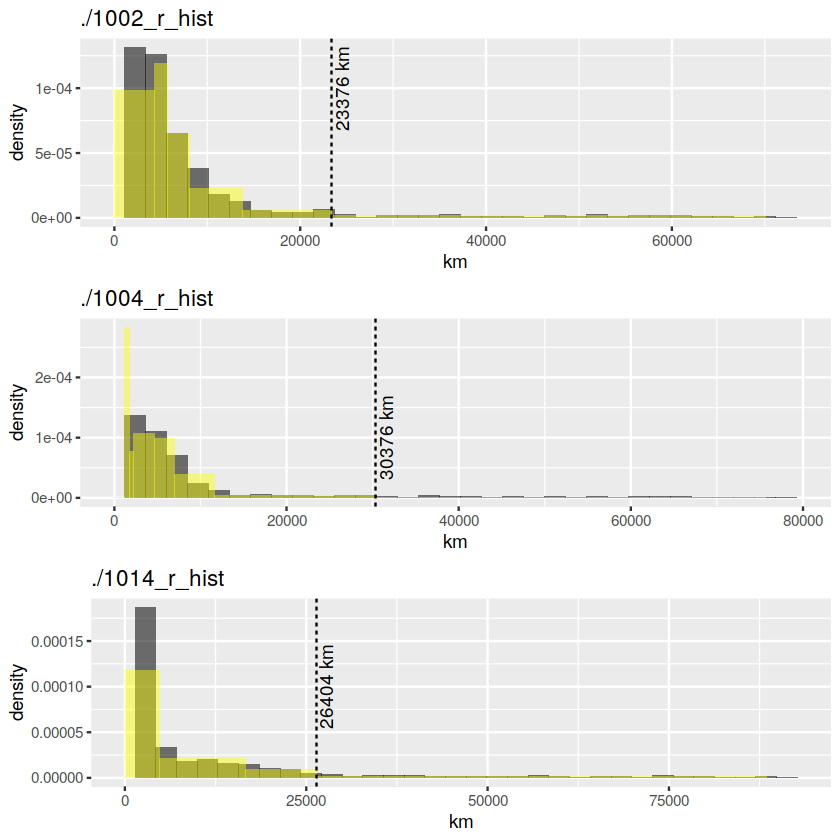

In [20]:
grid.arrange(p[[1]], p[[2]], p[[3]], heights=c(1,1,1), widths=c(1))